In [3]:
from topological_codes import RepetitionCode
from qiskit import Aer, assemble, transpile
import qiskit

import numpy as np

import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

In [4]:
nQ = 1
rb_opts = {}
rb_opts['length_vector'] = [1,10,20,50,75,100,125,150,175,200]
# num of seeds(random sequences)
rb_opts['nseeds'] = 5
#default pattern
rb_opts['rb_pattern'] = [[0]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [5]:
#Removing the measurement gate from the rb sequences
for i in range(len(rb_circs)):
    for j in range(len(rb_circs[0])):
        rb_circs[i][j].data
        rb_circs[i][j].data.pop(-1)

In [6]:
#Creating a 2D List for storing the rb sequences
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
rows, cols = (len(rb_circs), len(rb_circs[0]))
rb_circs_dlist = [[0]*cols]*rows

In [7]:
#Adding more registers to rb sequence
for i in range(len(rb_circs)):
    for j in range(len(rb_circs[0])):
        Q= QuantumRegister(5)
        C= ClassicalRegister(1)
        qc = QuantumCircuit(Q,C)
        qq = qc.compose(rb_circs[i][j],[3])
        qq.remove_final_measurements()
        rb_circs_dlist[i][j] = qq
# All the rb circuits without the measurement part

In [8]:
#Repetition code (d=3) creation
code_list = [[0]*cols]*rows
for i in range(len(rb_circs)):
    for j in range(len(rb_circs[0])):
        d= 3
        xbasis = False
        code = RepetitionCode(d,0,xbasis=xbasis)
        # type(code)
        # type(code.circuit['0'])
        code.syndrome_measurement()
        for logical in ['0','1']:
            code.circuit[logical] = code.circuit[logical].compose(rb_circs_dlist[i][j])
        code.syndrome_measurement()
        code_list[i][j] = code

In [9]:
backend = Aer.get_backend('aer_simulator')
#List for storing values of zero and one circuits
p_zero = []
p_one = []
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        circuit = code_list[i][j].get_circuit_list()
        job = backend.run(circuit)
        p = {}

        # logical 0
        counts = job.result().get_counts(0)
        if '010 11 00' in counts:
            r = counts['010 11 00']/counts['000 00 00']
            p['0'] = r/(1+r)
        else:
            p['0'] = 0
            
        # logical 1
        counts = job.result().get_counts(1)
        if '101 11 00' in counts:
            r = counts['101 11 00']/counts['111 00 00']
            p['1'] = r/(1+r)
        else:
            p['1'] = 0
            
        # print(p)
        p_zero.append(p['0'])
        p_one.append(p['1'])

In [10]:
#Code circuit list for measuring only the third qubit for EPC value calculation
code_list = [[0]*cols]*rows
for i in range(len(rb_circs)):
    for j in range(len(rb_circs[0])):
        d= 3
        xbasis = False
        code = RepetitionCode(d,0,xbasis=xbasis)
        # c = ClassicalRegister(1)
        # qc = QuantumCircuit(c)
        # type(code)
        # type(code.circuit['0'])
        code.syndrome_measurement()
        for logical in ['0','1']:
            # code.circuit[logical].data.pop(-1)
            # code.circuit[logical].data.pop(-1)
            # code.circuit[logical] = code.circuit[logical].compose(qc)
            code.circuit[logical].remove_final_measurements()
            code.circuit[logical] = code.circuit[logical].compose(rb_circs_dlist[i][j])
        code.syndrome_measurement()
        code.readout()
        for logical in ['0','1']:
        #     code.circuit[logical].data.pop(-1)
        #     code.circuit[logical].data.pop(-1)
        #     code.circuit[logical].data.pop(-1)
        #     code.circuit[logical].data.pop(-1)
        #     code.circuit[logical].data.pop(-1)
        #     code.circuit[logical].measure(3,5)
              code.circuit[logical].remove_final_measurements()
              c = ClassicalRegister(1)
              code.circuit[logical].add_register(c)
              code.circuit[logical].measure(3,0)
        
        
        code_list[i][j] = code

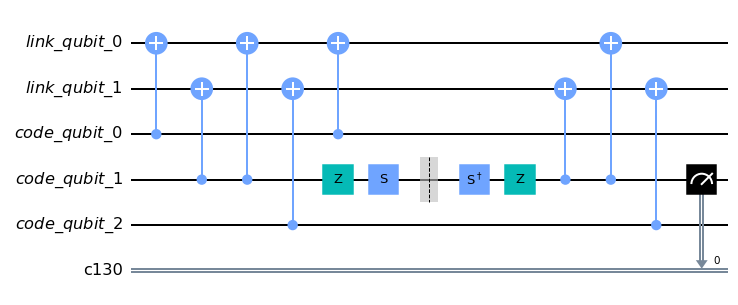

In [11]:
code_list[0][0].circuit['0'].draw('mpl')

In [12]:
#For the '0' Repetition Code circuits
rb_circs_zero = [[0]*cols]*rows
#print(len(rb_circs_zero))
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        rb_circs_zero[i][j] = code_list[i][j].circuit['0']

In [13]:
#For the '1' Repetition Code circuits
rb_circs_one = [[0]*cols]*rows
#print(len(rb_circs_one))
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        rb_circs_one[i][j] = code_list[i][j].circuit['0']

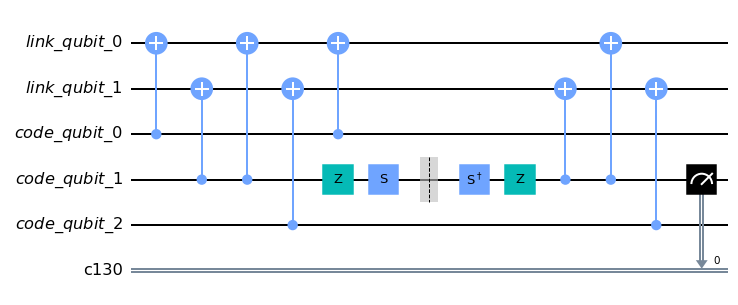

In [14]:
code_list[0][0].circuit['0'].draw('mpl')

In [16]:
#verify that the unitary representing each RB circuit is identity using Aer 
from qiskit import QuantumCircuit
# new circuit without measurement
qregs = rb_circs_zero[0][-1].qregs
cregs = rb_circs_zero[0][-1].cregs
qc = QuantumCircuit(*qregs,*cregs)
for i in rb_circs_zero[0][-1][0:-nQ]:
    qc.data.append(i)
    
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

In [17]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

The below code is giving errors and need to be fixed.

In [ ]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
print(type(rb_fit))
for rb_seed, rb_circ_seed in enumerate(rb_circs_zero):
    print(type(rb_circ_seed))
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    #print((job.result()))
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

In [19]:
# count the number of single and 2Q gates in the 2Q Cliffords
qubits = rb_opts['rb_pattern'][0]

gate_per_cliff = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpiled_circs_list,
    clifford_lengths=xdata[0],
    basis=basis_gates,
    qubits=qubits)

for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f"%(
        basis_gate,
        np.mean([gate_per_cliff[qubit][basis_gate] for qubit in qubits])))

Number of u1 gates per Clifford: 0.000000
Number of u2 gates per Clifford: 0.000000
Number of u3 gates per Clifford: 0.000000
Number of cx gates per Clifford: 0.043668


The below code is giving errors and need to be fixed, as the error cannot be zero!

In [24]:
p1Q = 0.01
p2Q = 0.02
# convert from depolarizing error to epg (1Q)
epg_q0 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}
epg_q1 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}

# convert from depolarizing error to epg (2Q)
epg_q01 = 3/4 * p2Q

# calculate the predicted epc from underlying gate errors 
pred_epc = rb.rb_utils.calculate_1q_epc(
    gate_per_cliff=gate_per_cliff,epg_1q=epg_q0,qubit=0)

print("Predicted 1Q Error per Clifford: %e" % (pred_epc))

Predicted 1Q Error per Clifford: 0.000000e+00


In [25]:
#Run on noisy simulator
p1q_list = np.linspace(0.0,0.02,num=10)
p2q_list = np.linspace(0.0,0.01,num=10)

for p1Q,p2Q in zip(p1q_list,p2q_list):
    
# # Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
# p1Q = 0.02
# p2Q = 0.01
    noise_model = NoiseModel()
    # noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
    # noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
    backend = Aer.get_backend('aer_simulator')
    np_zero = []
    np_one = []
    for i in range(len(code_list)):
        for j in range(len(code_list[0])):
            ncircuit = code_list[i][j].get_circuit_list()
            noisy_job = backend.run(ncircuit,noise_model=noise_model,max_parallel_experiments=0)
            noisy_p = {}
            # logical 0
            noisy_counts = noisy_job.result().get_counts(0)
            if '010 11 00' in noisy_counts:
                noisy_r = noisy_counts['010 11 00']/noisy_counts['000 00 00']
                noisy_p['0'] = noisy_r/(1+noisy_r)
            else:
                noisy_p['0'] = 0
                
            # logical 1
            noisy_counts = noisy_job.result().get_counts(1)
            if '101 11 00' in noisy_counts:
                noisy_r = noisy_counts['101 11 00']/noisy_counts['111 00 00']
                noisy_p['1'] = noisy_r/(1+noisy_r)
            else:
                noisy_p['1'] = 0
                
            # print(noisy_p)
            np_zero.append(noisy_p['0'])
            np_one.append(noisy_p['1'])

No handles with labels found to put in legend.


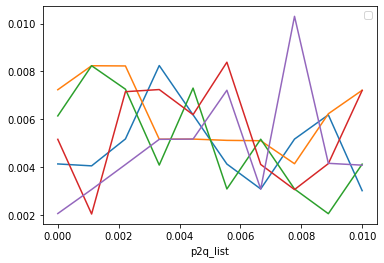

In [101]:
#Plot of rb sequences - No practical use as such
fig2 = plt.figure()
plt.plot(p2q_list,np_zero[0:10])
plt.plot(p2q_list,np_zero[10:20])
plt.plot(p2q_list,np_zero[20:30])
plt.plot(p2q_list,np_zero[30:40])
plt.plot(p2q_list,np_zero[40:50])
plt.xlabel('p2q_list')
plt.legend()
plt.show()

In [95]:
#Run on noisy simulator
p1q_list = np.linspace(0.0,0.02,num=10)
p2q_list = np.linspace(0.0,0.01,num=10)

for p1Q,p2Q in zip(p1q_list,p2q_list):
    
# # Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
# p1Q = 0.02
# p2Q = 0.01
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
    backend = Aer.get_backend('aer_simulator')
    np_zero = []
    np_one = []
    for i in range(len(code_list)):
        for j in range(len(code_list[0])):
            ncircuit = code_list[i][j].get_circuit_list()
            noisy_job = backend.run(ncircuit,noise_model=noise_model,max_parallel_experiments=0)
            noisy_p = {}
            # logical 0
            noisy_counts = noisy_job.result().get_counts(0)
            if '010 11 00' in noisy_counts:
                noisy_r = noisy_counts['010 11 00']/noisy_counts['000 00 00']
                noisy_p['0'] = noisy_r/(1+noisy_r)
            else:
                noisy_p['0'] = 0
                
            # logical 1
            noisy_counts = noisy_job.result().get_counts(1)
            if '101 11 00' in noisy_counts:
                noisy_r = noisy_counts['101 11 00']/noisy_counts['111 00 00']
                noisy_p['1'] = noisy_r/(1+noisy_r)
            else:
                noisy_p['1'] = 0
                
            # print(noisy_p)
            np_zero.append(noisy_p['0'])
            np_one.append(noisy_p['1'])

No handles with labels found to put in legend.


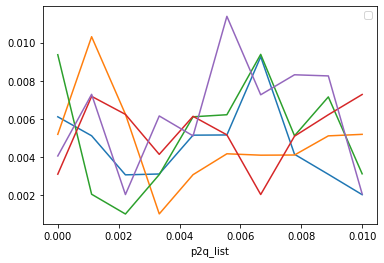

In [99]:
#Plot of rb sequences - No practical use as such
fig2 = plt.figure()
plt.plot(p2q_list,np_zero[0:10])
plt.plot(p2q_list,np_zero[10:20])
plt.plot(p2q_list,np_zero[20:30])
plt.plot(p2q_list,np_zero[30:40])
plt.plot(p2q_list,np_zero[40:50])
plt.xlabel('p2q_list')
plt.legend()
plt.show()

RB Fitter giving issues which need to be fixed.

In [ ]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
print(type(rb_fit))
for rb_seed, rb_circ_seed in enumerate(rb_circs_zero):
    print(type(rb_circ_seed))
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=2)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

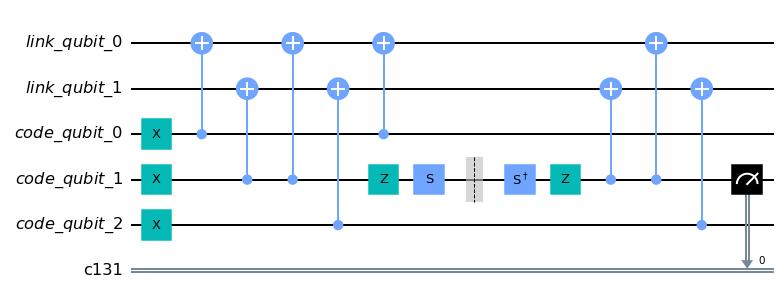

In [26]:
code_list[0][0].circuit['1'].draw('mpl')

In [27]:
backend = Aer.get_backend('aer_simulator')
p_zero = []
p_one = []
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        circuit = code_list[i][j].get_circuit_list()
        job = backend.run(circuit)
        p = {}

        # logical 0
        counts = job.result().get_counts(0)
        if '010 11 00' in counts:
            r = counts['010 11 00']/counts['000 00 00']
            p['0'] = r/(1+r)
        else:
            p['0'] = 0
            
        # logical 1
        counts = job.result().get_counts(1)
        if '101 11 00' in counts:
            r = counts['101 11 00']/counts['111 00 00']
            p['1'] = r/(1+r)
        else:
            p['1'] = 0
            
        # print(p)
        p_zero.append(p['0'])
        p_one.append(p['1'])
        

In [28]:
#Run on noisy simulator

noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.02
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [ ]:
backend = Aer.get_backend('aer_simulator')
np_zero = []
np_one = []
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        ncircuit = code_list[i][j].get_circuit_list()
        noisy_job = backend.run(ncircuit,noise_model=noise_model,max_parallel_experiments=0)
        noisy_p = {}
        # logical 0
        noisy_counts = noisy_job.result().get_counts(0)
        if '010 11 00' in noisy_counts:
            noisy_r = noisy_counts['010 11 00']/noisy_counts['000 00 00']
            noisy_p['0'] = noisy_r/(1+noisy_r)
        else:
            noisy_p['0'] = 0
            
        # logical 1
        noisy_counts = noisy_job.result().get_counts(1)
        if '101 11 00' in noisy_counts:
            noisy_r = noisy_counts['101 11 00']/noisy_counts['111 00 00']
            noisy_p['1'] = noisy_r/(1+noisy_r)
        else:
            noisy_p['1'] = 0
            
        # print(noisy_p)
        np_zero.append(noisy_p['0'])
        np_one.append(noisy_p['1'])

In [1]:
#np_zero

In [30]:
rb_circs_zero = [[0]*cols]*rows
#print(len(rb_circs_zero))
for i in range(len(code_list)):
    for j in range(len(code_list[0])):
        rb_circs_zero[i][j] = code_list[i][j].circuit['0']

TO DO :Need to solve/fix the RB Fitter issues, and the zero error value issue.